# G2M Insights for Cab Investment Firm


In [2]:
#Importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from geopy.geocoders import Nominatim
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Data Preparation

In [3]:
#Read in Csv file
Cab_Data = pd.read_csv('Cab_Data.csv')
#Create the dataframe from the read in file
cab_df= pd.DataFrame(Cab_Data)

In [4]:
#Looking at the date of travel column
date = cab_df['Date of Travel']
#sorting the column in numerical order
date1 = date.sort_values()
#creating a dataframe from the unique values from date1
date2 = pd.DataFrame(date1.unique())
#Adding a new column from the given information supplied in the intial posting and incrementing by the number of rows in the dataframe
date2['Date'] = pd.date_range(start='2016-01-01',periods=date2.shape[0])  
#Renaming the column to match the cab_df dataframe
date2.rename(columns={date2.columns[0]:"Date of Travel"}, inplace=True)
#merging the cab_df dataframe and the date2 dataframe to get the Date column
cab_date = cab_df.merge(date2, on='Date of Travel', how='left')

In [5]:
#Creating New Columns for Day of Week, Month, Week, Year to potentially use in our EDA
cab_date['Day of Week']=cab_date['Date'].dt.strftime('%A')
cab_date['Month']=cab_date['Date'].dt.month_name()
cab_date['Week']= cab_date['Date'].dt.isocalendar().week
cab_date['Year']=cab_date['Date'].dt.year

In [6]:
#Reading in additional City data to see if there are any similarities between the datasets
City_Data= pd.read_csv('City.csv')
city_df= pd.DataFrame(City_Data)

In [7]:
#This is for our Geospatial map 
geolocator = Nominatim(user_agent='MyGeolocator')
city_df['Location']=city_df.City.apply(geolocator.geocode)
city_df['Lat']=[Location.latitude for Location in city_df.Location]
city_df['Long']=[Location.longitude for Location in city_df.Location]

In [8]:
Cust_ID = pd.read_csv("Customer_ID.csv")
custID_df= pd.DataFrame(Cust_ID)

In [9]:
Trans_ID= pd.read_csv('Transaction_ID.csv')
transID_df= pd.DataFrame(Trans_ID)

In [10]:
#customer ID was also in Transaction ID dataset so we merged both dataframes on the customer ID 
cust_trans_ID = transID_df.merge(custID_df, on='Customer ID', how='inner')

In [11]:
#Merging cust_trans_id to the main Cab dataset
cab_new = cab_date.merge(cust_trans_ID, on='Transaction ID', how="inner")

In [12]:
#merging the final dataset(city dataset) to create the master dataset with all the data
cab_all= cab_new.merge(city_df, on="City", how='left')

In [13]:
#Converting all spaces in column names to underscores
cab_all.columns = cab_all.columns.str.replace(' ', '_')
#Converting Kilometers to Miles for the distance travelled 
cab_all['M_Travelled']= round(cab_all['KM_Travelled'] / 1.609, 2)
#Adding a profit/loss column for every ride
cab_all['Ride_Profit']= (cab_all['Price_Charged']-cab_all['Cost_of_Trip'])

In [14]:
#finding duplicates in the new dataframe
#no duplicate transactions, there will be duplicate values in calumns like city, date of travel, date, etc.
cab_all['Transaction_ID'].duplicated().sum()

0

In [15]:
#checking for NaN/Null/Missing Values
cab_all.isnull().values.any() 
#no null values
#cab_all.isnull().sum()

False

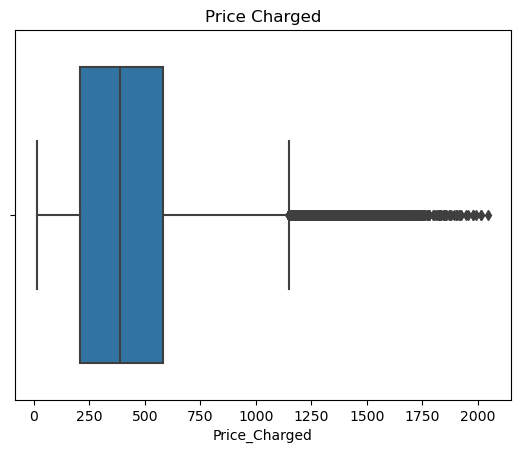

In [16]:
#getting basic descriptive statistics of our data
cab_all.describe()
# boxplot to visualize outliers
sns.boxplot(x= cab_all['Price_Charged'])
plt.title('Price Charged')
plt.show()
#We find that the columns that have outliers are the Price Charged column and Ride Profit column (Not apart of original dataset)
#
# We create a function to look deeper into the Price Charged outliers

def find_outliers(d1):
    q1 = d1.quantile(0.25)
    q3 = d1.quantile(0.75)
    IQR = q3-q1
    lower_bound = q1 - (1.5*IQR)
    upper_bound = q3 + (1.5*IQR)
    outliers = cab_all[(d1<lower_bound) | (d1>upper_bound)]
    return outliers

def find_lowerbound(d1):
    q1 = d1.quantile(0.25)
    q3 = d1.quantile(0.75)
    IQR = q3-q1
    lower_bound = q1 - (1.5*IQR)
    return lower_bound

def find_upperbound(d1):
    q1 = d1.quantile(0.25)
    q3 = d1.quantile(0.75)
    IQR = q3-q1
    upper_bound = q3 + (1.5*IQR)
    return upper_bound

#This will return a dataset of all of the data that is higher/lower than the outlier
price_charged_outliers = find_outliers(cab_all['Price_Charged'])
price_charged_lower = find_lowerbound(cab_all['Price_Charged'])
price_charged_upper = find_upperbound(cab_all['Price_Charged'])
#There are 5958 outliers(Price Charged), since this is ~2% (5958 / 359392) of the data which is not significant so i will not remove it
#Our upper bound(Price Charged) cut off is ~$1149.50 anything over this price is considered an outlier

# Exploratory Data Analysis (EDA)

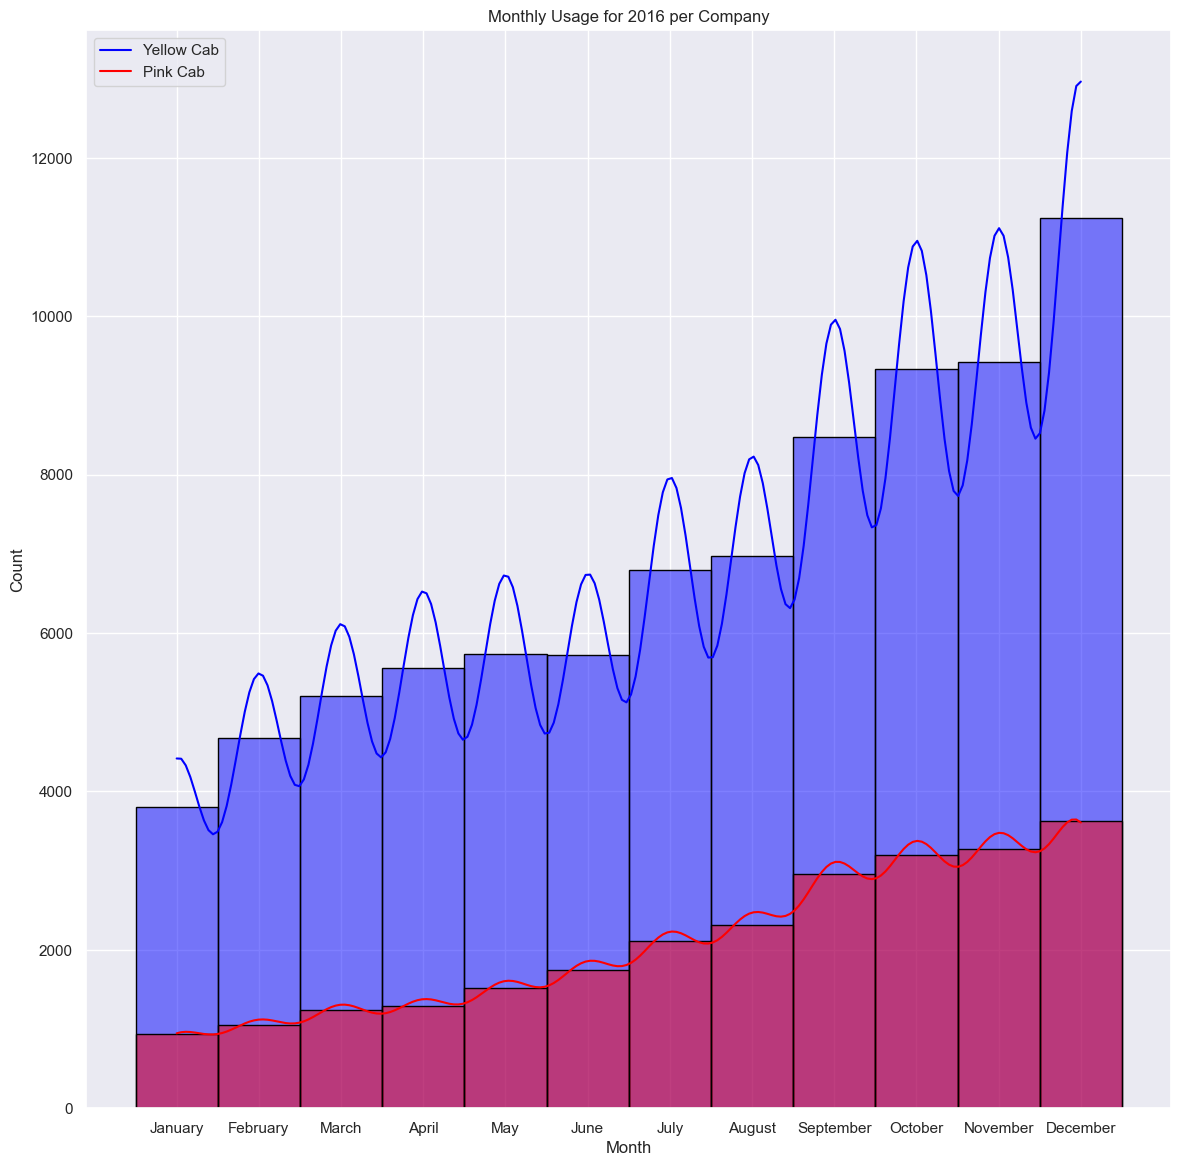

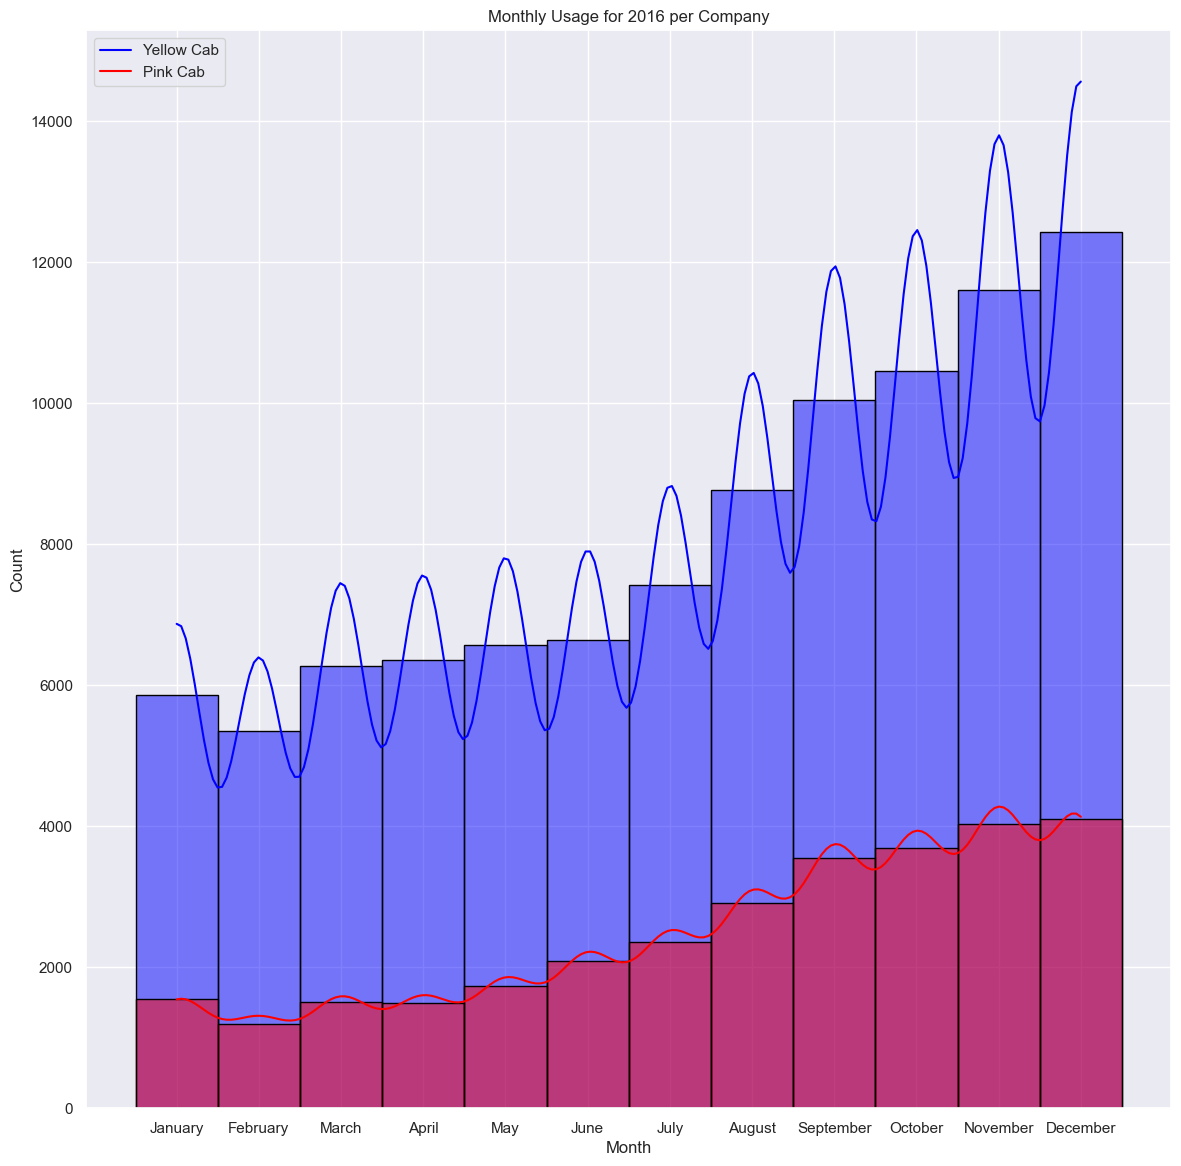

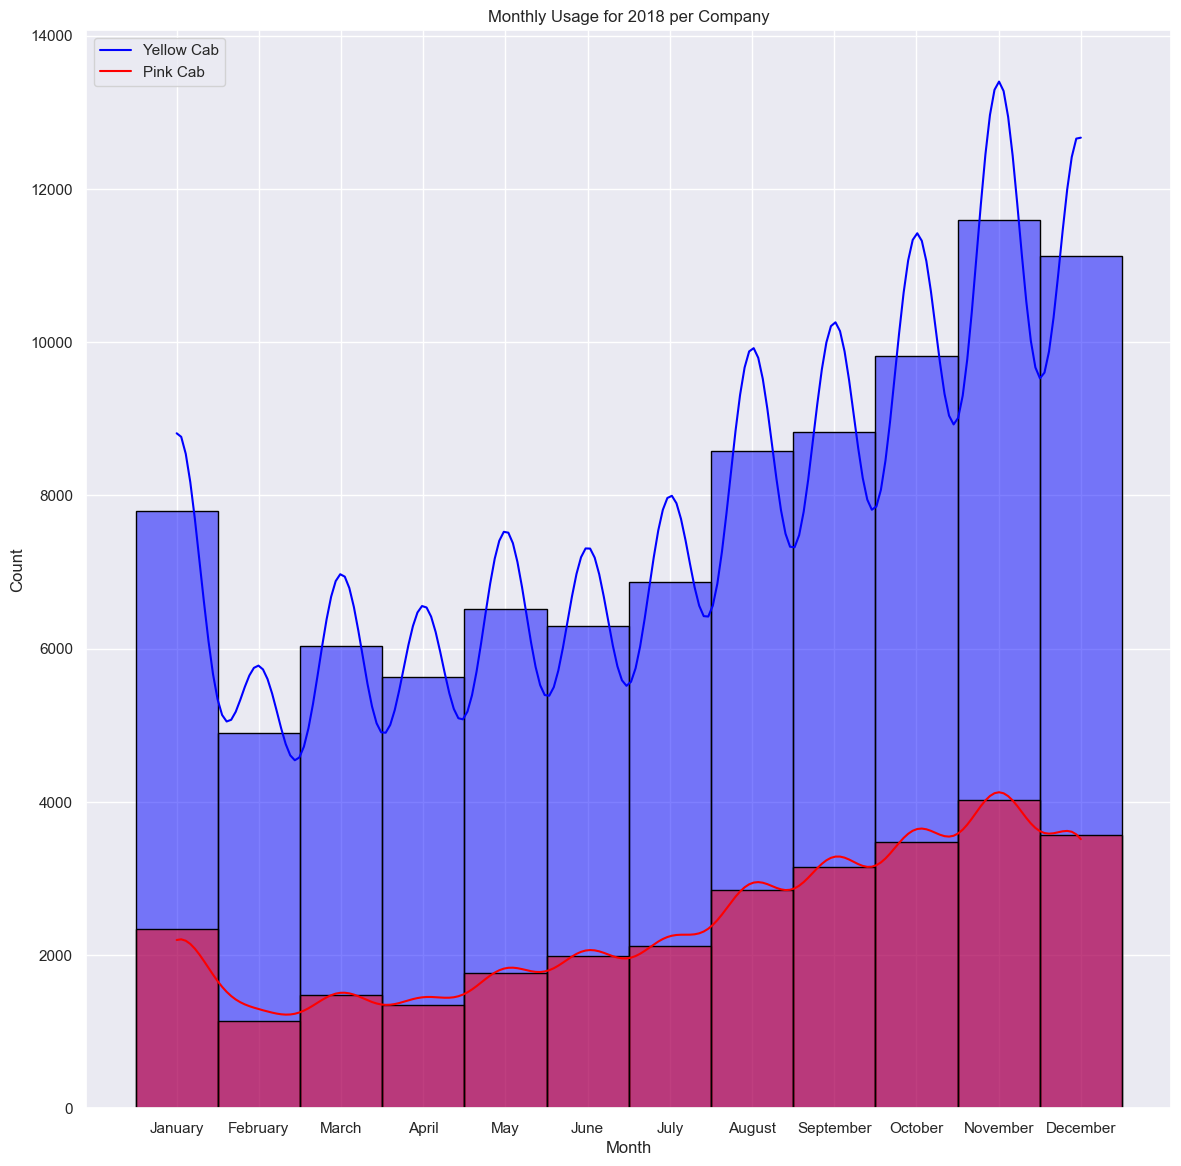

In [17]:
#Checking if there will be seasonality in the usage of the cab services
#Monthly breakdown of cab Usage by year
#2016
sns.set(rc={'figure.figsize':(14,14)})
sns.histplot(cab_all[(cab_all['Company'] == 'Yellow Cab') & (cab_all['Year']==2016)].Month, color='blue', kde=True, edgecolor='black')
sns.histplot(cab_all[(cab_all['Company'] == 'Pink Cab') & (cab_all['Year'] == 2016)].Month, color='red', kde=True, edgecolor='black')
plt.title('Monthly Usage for 2016 per Company')
plt.legend(['Yellow Cab', 'Pink Cab'])
plt.show()
#2017
sns.histplot(cab_all[(cab_all['Company'] == 'Yellow Cab') & (cab_all['Year']==2017)].Month, color='blue', kde=True, edgecolor='black')
sns.histplot(cab_all[(cab_all['Company'] == 'Pink Cab') & (cab_all['Year'] == 2017)].Month, color='red', kde=True, edgecolor='black')
plt.title('Monthly Usage for 2016 per Company')
plt.legend(['Yellow Cab', 'Pink Cab'])
plt.show()

#2018
sns.histplot(cab_all[(cab_all['Company'] == 'Yellow Cab') & (cab_all['Year']==2018)].Month, color='blue', kde=True, edgecolor='black')
sns.histplot(cab_all[(cab_all['Company'] == 'Pink Cab') & (cab_all['Year'] == 2018)].Month, color='red', kde=True, edgecolor='black')
plt.title('Monthly Usage for 2018 per Company')
plt.legend(['Yellow Cab', 'Pink Cab'], loc= 'upper left')
plt.show()
#There is seasonality in the usage of the cab services we see that there is an influx of users during the Holiday season each year

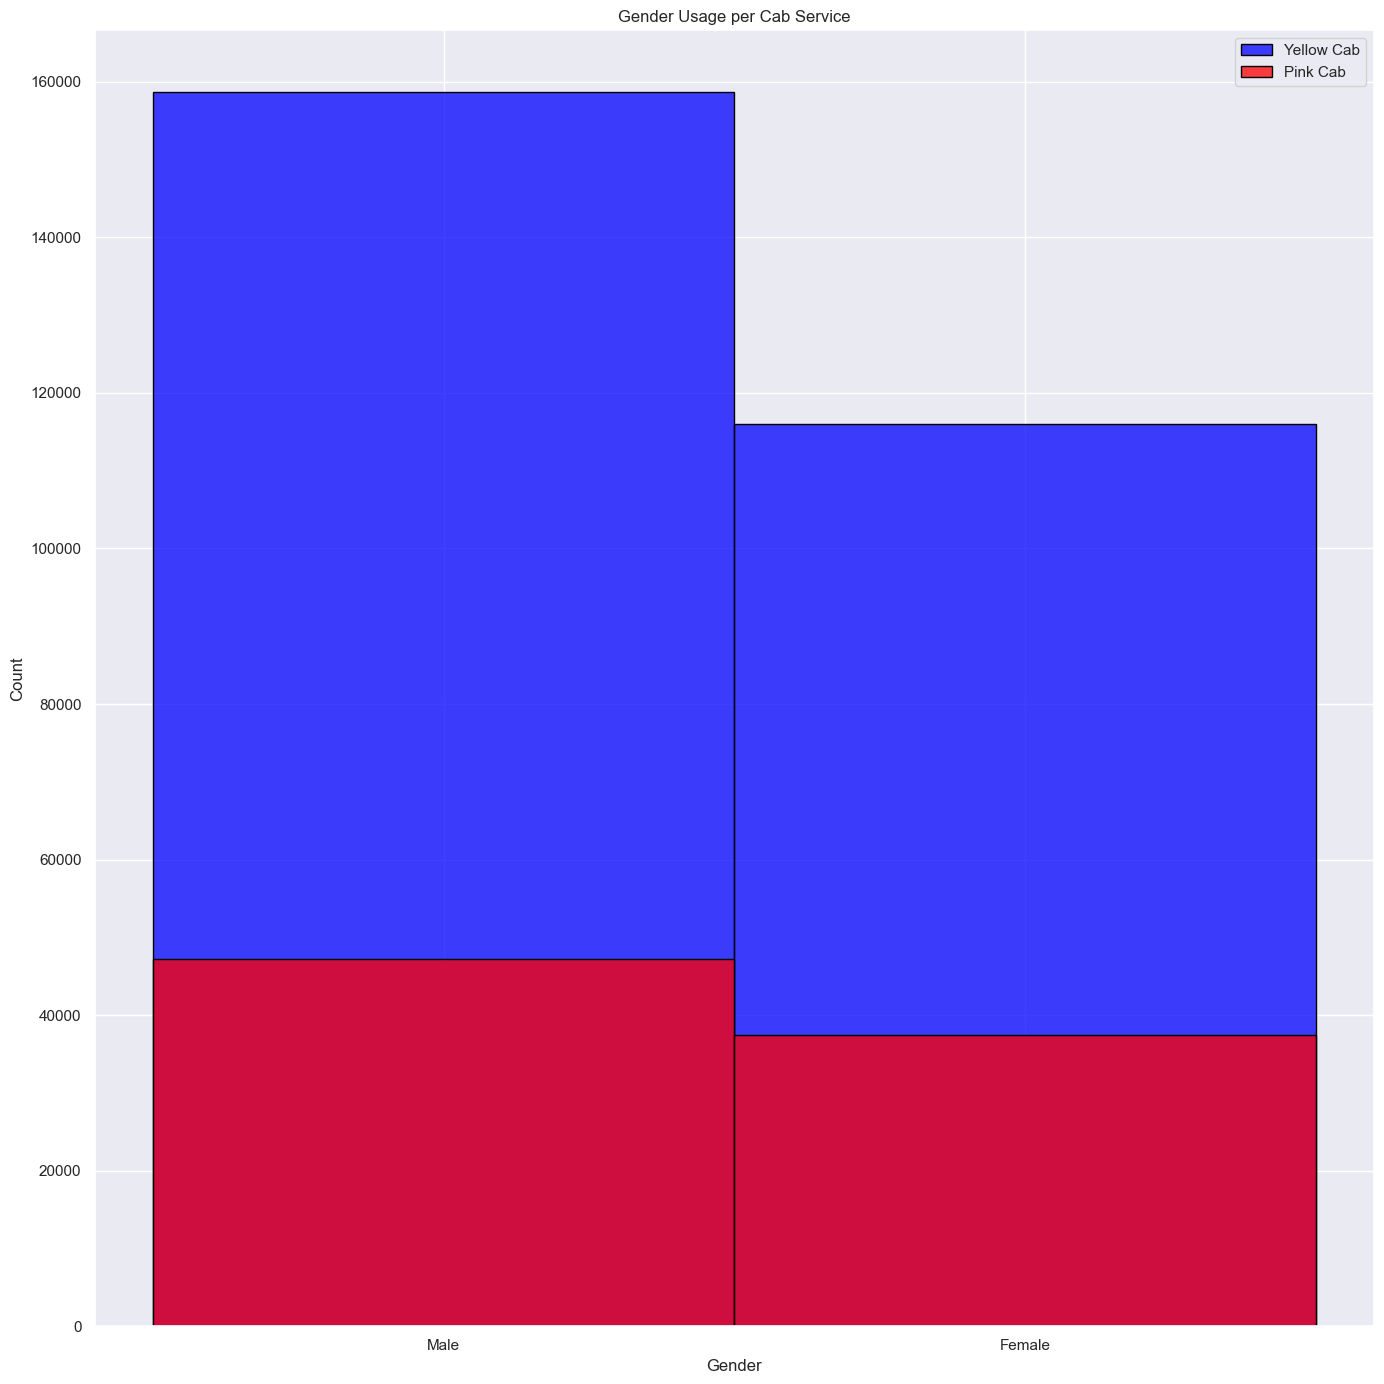

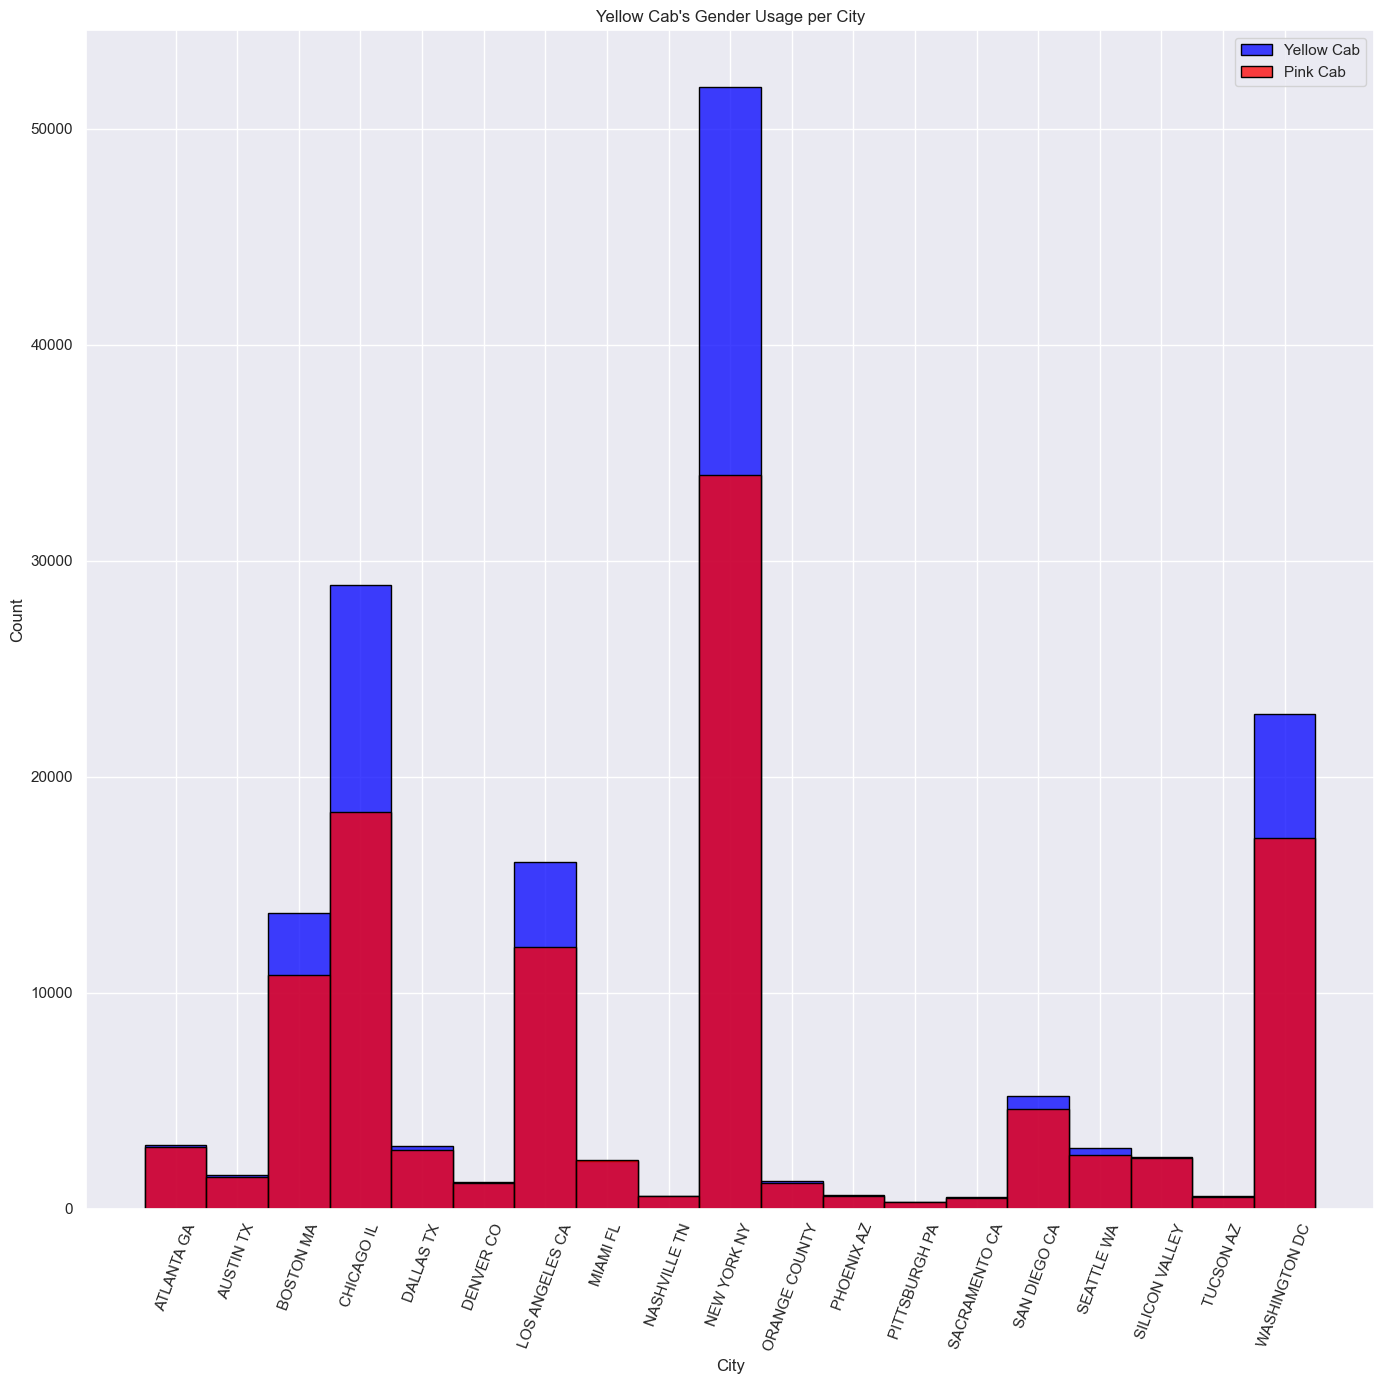

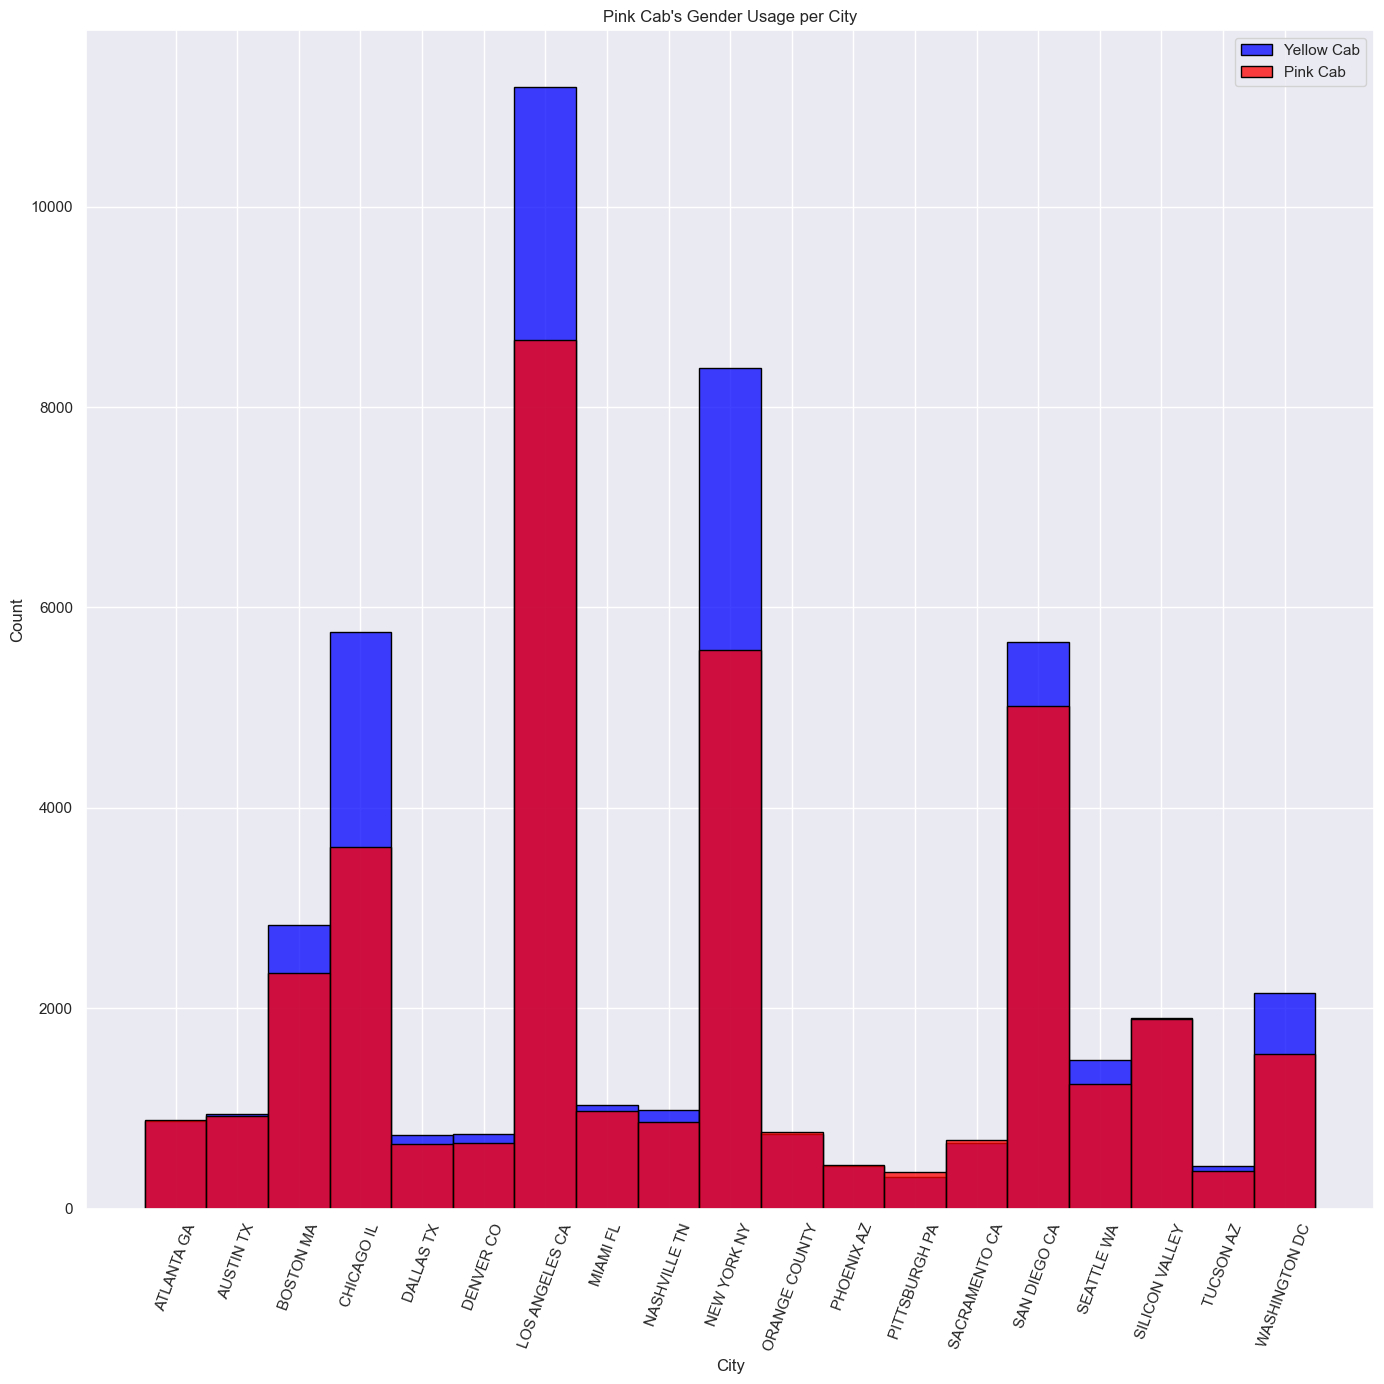

In [18]:
#Checking if the Gender with the most usage will be Males

#Checking if Males will use Yellow Cab more than Females and Females will use Pink Cab more than Males
sns.histplot(cab_all[cab_all.Company == 'Yellow Cab'].Gender,color='blue', edgecolor='black')
sns.histplot(cab_all[cab_all.Company == 'Pink Cab'].Gender, color='red', edgecolor='black')
plt.title("Gender Usage per Cab Service")
plt.tight_layout()
plt.legend(['Yellow Cab', 'Pink Cab'])
plt.show()
#Our assumption was wrong, they were approximately even in most cities except a few where males used yellowcab more

#Gender per Yellow Cab per city
sns.histplot(cab_all[(cab_all.Gender == 'Male') & (cab_all.Company == 'Yellow Cab')].City, color='blue', bins=20, edgecolor='black')
sns.histplot(cab_all[(cab_all.Gender =='Female') & (cab_all.Company == 'Yellow Cab')].City, color='red', bins=20, edgecolor='black')
plt.xticks(rotation=70, ha='center')
plt.title("Yellow Cab's Gender Usage per City")
plt.tight_layout()
plt.legend(['Yellow Cab', 'Pink Cab'])
plt.show()

#Gender per Pink Cab per City
sns.histplot(cab_all[(cab_all.Gender == 'Male') & (cab_all.Company == 'Pink Cab')].City, color='blue', bins=20, edgecolor='black')
sns.histplot(cab_all[(cab_all.Gender =='Female') & (cab_all.Company == 'Pink Cab')].City, color='red', bins=20, edgecolor='black')
plt.xticks(rotation=70, ha='center')
plt.title("Pink Cab's Gender Usage per City")
plt.tight_layout()
plt.legend(['Yellow Cab', 'Pink Cab'])
plt.show() 
#The gender usage is more almost even in the smaller city but for the major cities Males are still predominantly using the cab services


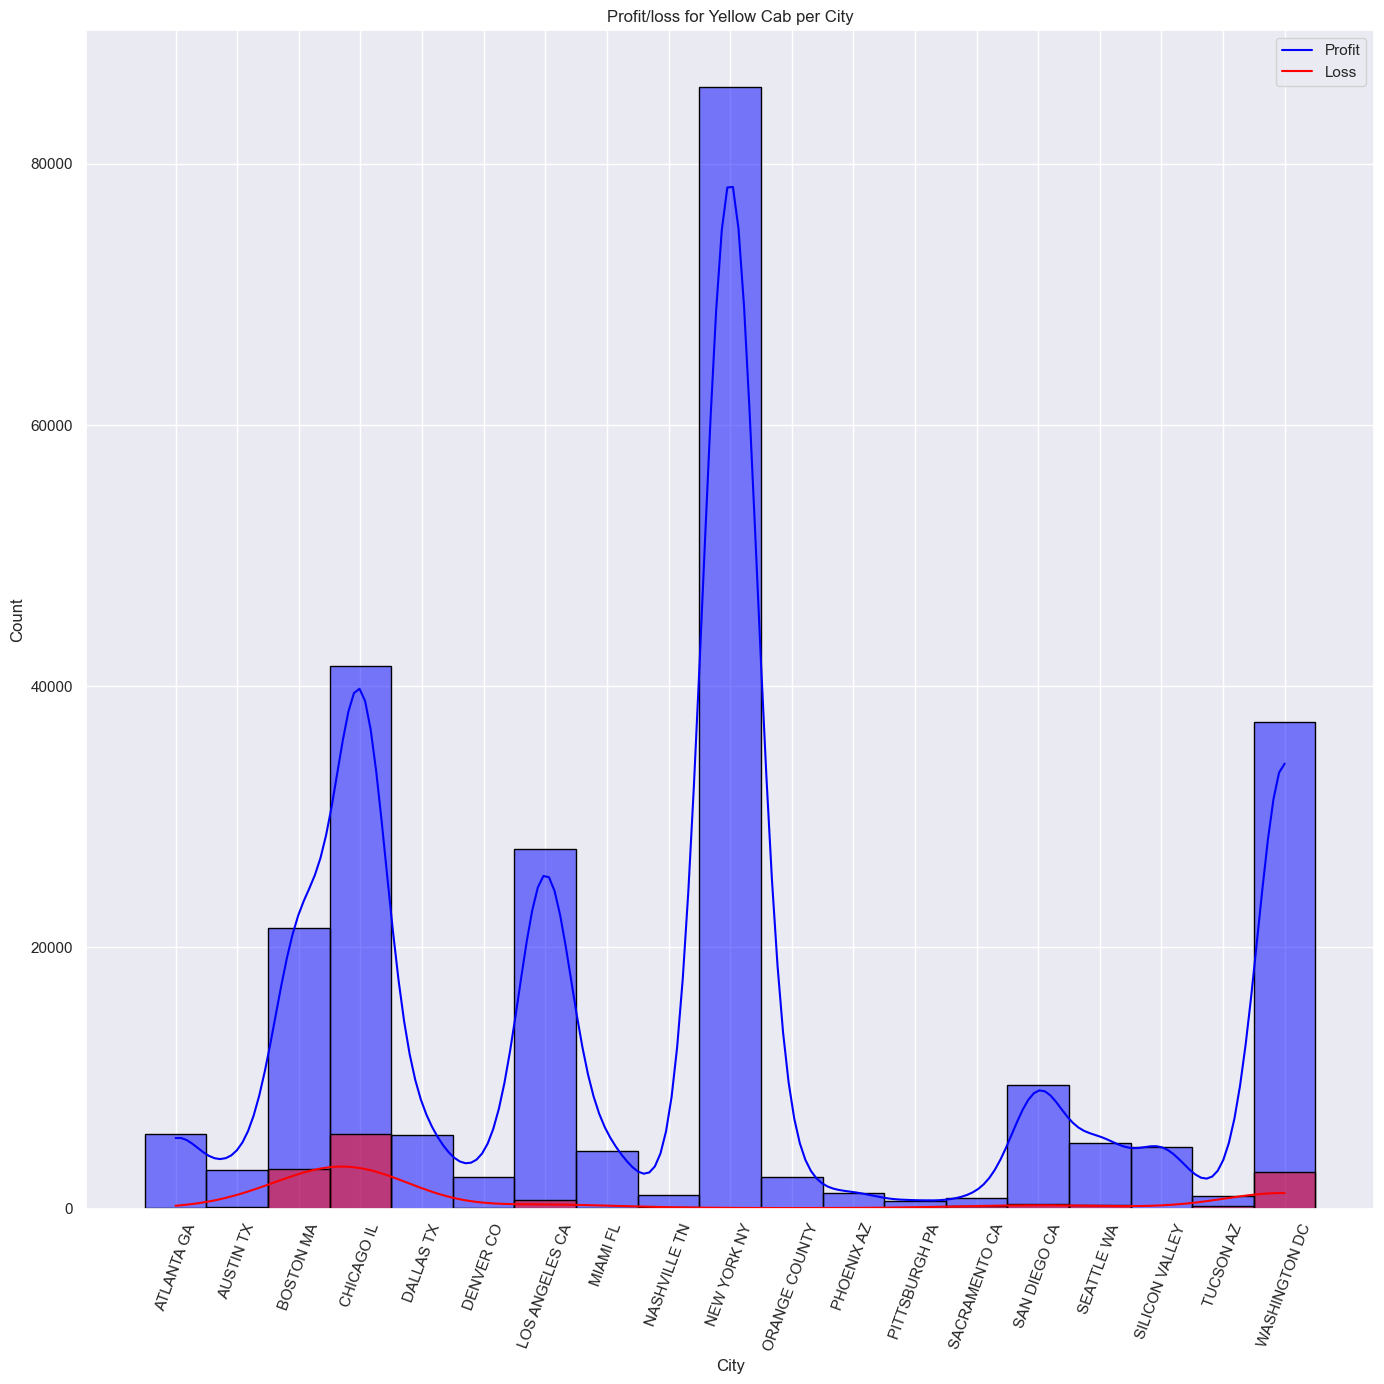

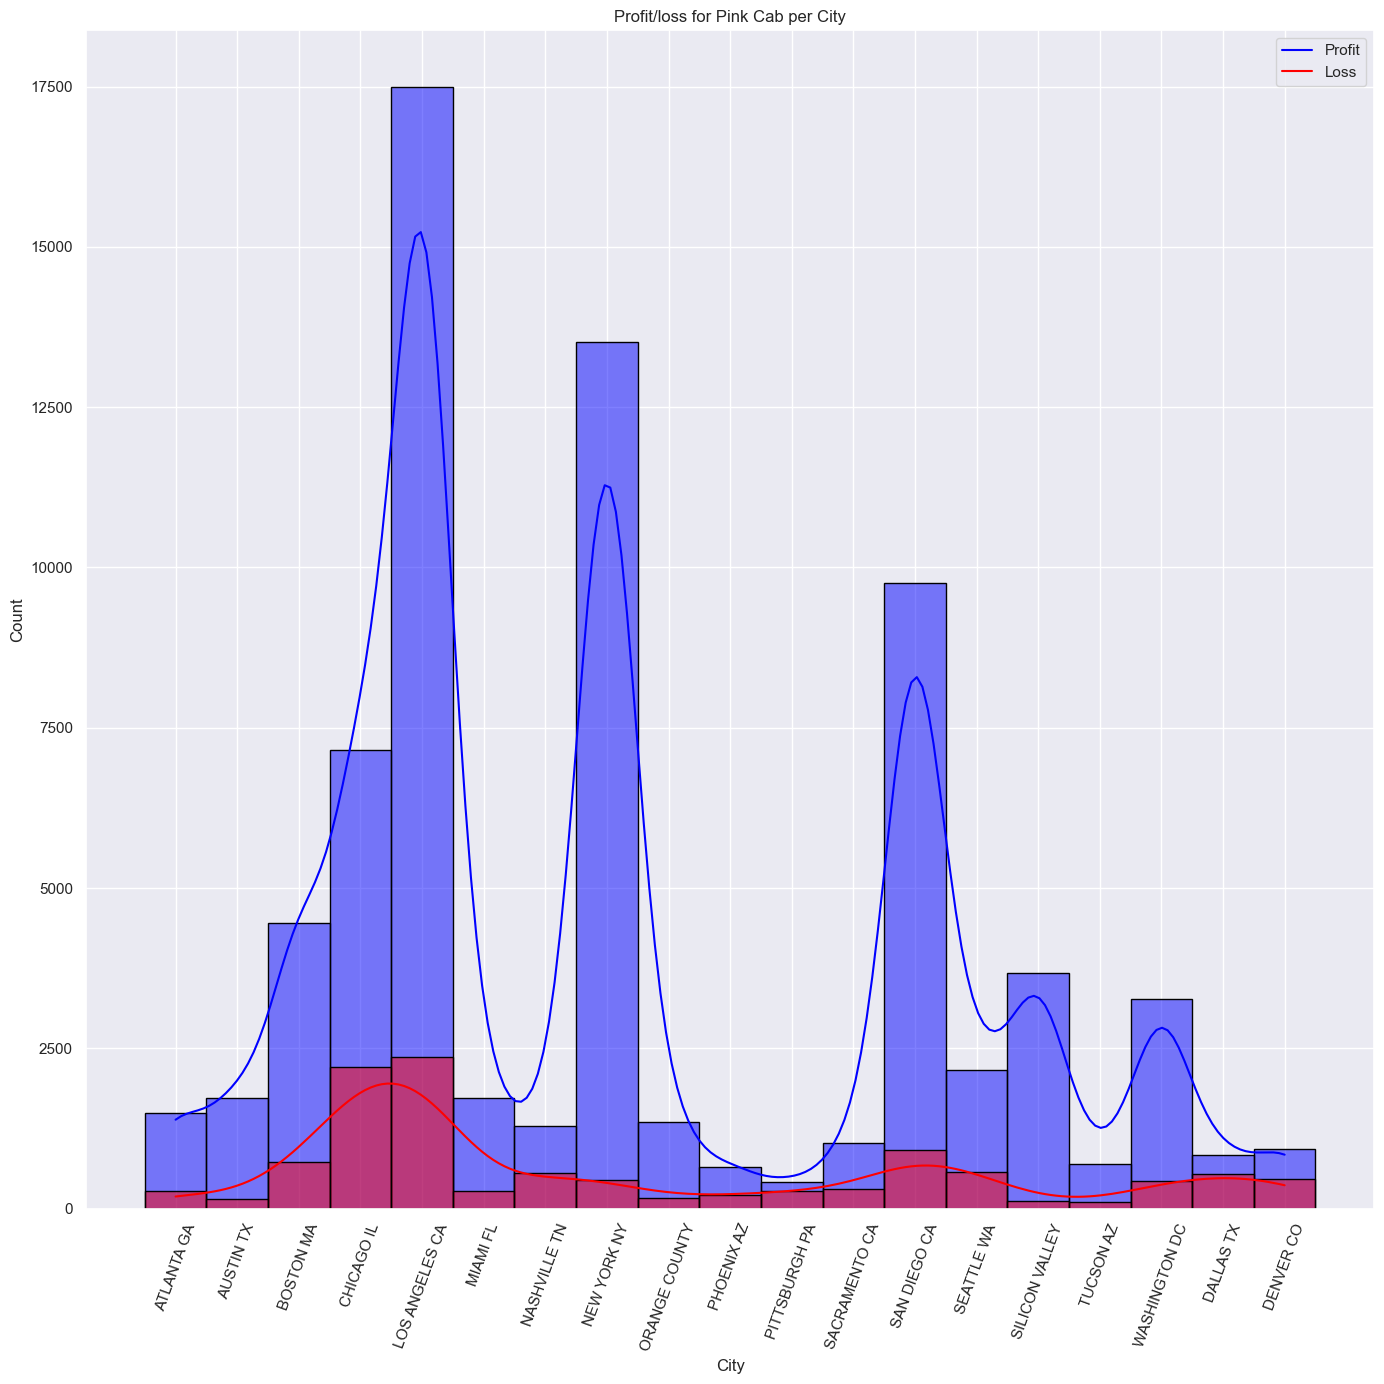

In [19]:
#Profit/Loss per Company
#Yellow Cab Profit/Loss per City
sns.histplot(cab_all[(cab_all['Ride_Profit'] >= 0) & (cab_all.Company == 'Yellow Cab')].City, color='blue', kde=True, edgecolor='black')
sns.histplot(cab_all[(cab_all['Ride_Profit'] < 0) & (cab_all.Company == 'Yellow Cab')].City, color='red', kde=True, edgecolor='black')
plt.xticks(rotation=70, ha='center')
plt.title("Profit/loss for Yellow Cab per City")
plt.tight_layout()
plt.legend(['Profit', 'Loss'])
plt.show()

#Pink Cab Profit/Loss per City
sns.histplot(cab_all[(cab_all['Ride_Profit'] >= 0) & (cab_all.Company == 'Pink Cab')].City, color='blue', kde=True, edgecolor='black')
sns.histplot(cab_all[(cab_all['Ride_Profit'] < 0) & (cab_all.Company == 'Pink Cab')].City, color='red', kde=True, edgecolor='black')
plt.xticks(rotation=70, ha='center')
plt.title("Profit/loss for Pink Cab per City")
plt.tight_layout()
plt.legend(['Profit', 'Loss'])
plt.show()

In [1]:
#Creating a Geospatial Map of our Daily data based on Locations and price charged
cab_date_sorted=cab_all.sort_values('Date')
cab_mean_dates= cab_date_sorted.groupby(['Date', 'City', 'Company']).mean(['Price_Charged']).reset_index()
cab_mean_dates['Date_Str']=pd.to_datetime(cab_mean_dates['Date']).dt.date.astype(str)
cab_mean_dates
fig = px.scatter_geo(cab_mean_dates, lon=cab_mean_dates['Long'], lat=cab_mean_dates['Lat'], locationmode='USA-states', size='Price_Charged', symbol='Company', color='City', color_continuous_scale='Viridis_r', scope='usa', animation_frame='Date_Str', title='Timeline of the Average Price Charged per City')
fig.update_traces(marker_line_width=1, marker_line_color='black')
fig.show()

NameError: name 'cab_all' is not defined

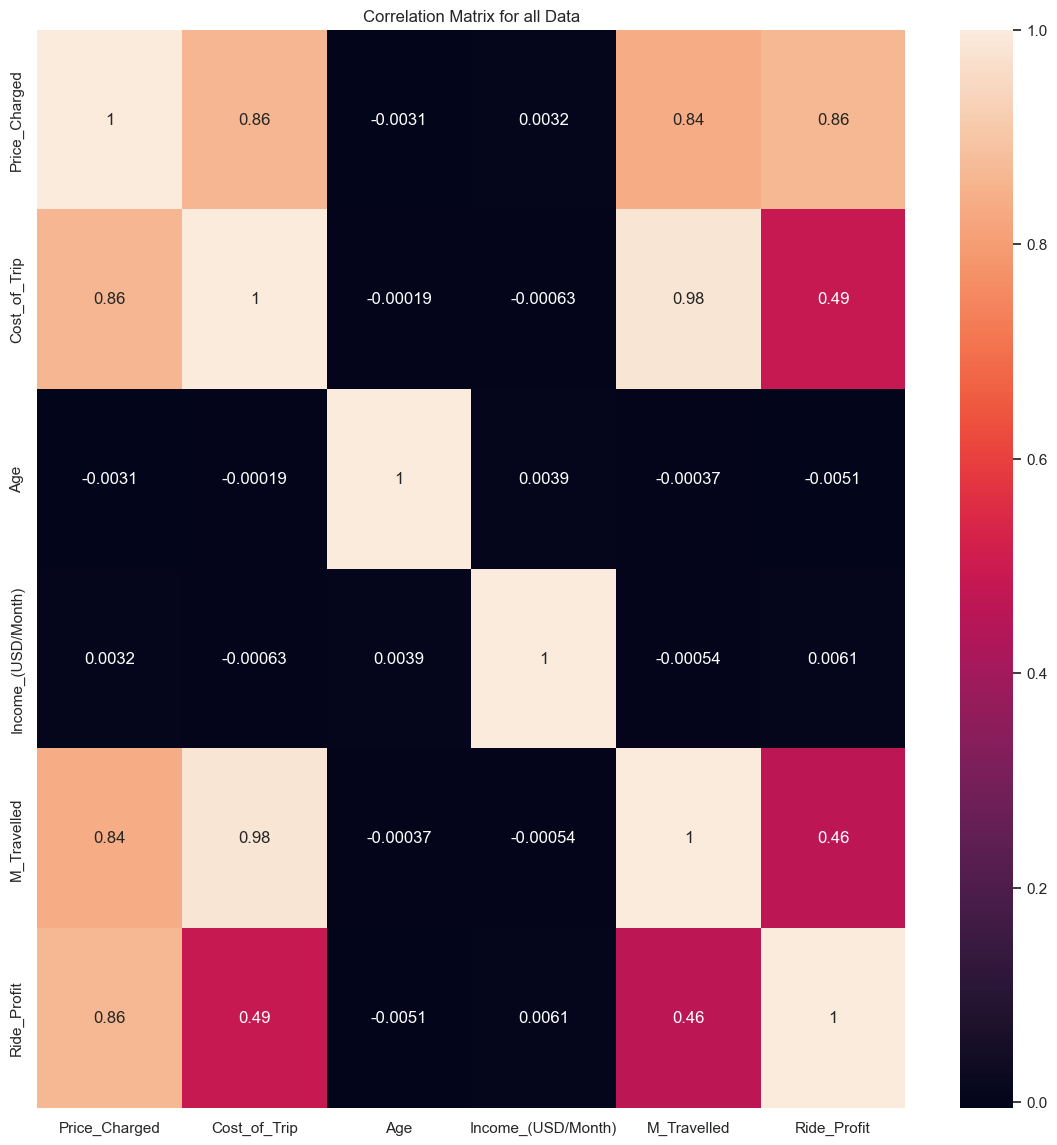

In [ ]:
#Correlation matrix for entire dataset and each Company
corr_cols = cab_all[['Company','Price_Charged', 'Cost_of_Trip', 'Age', 'Income_(USD/Month)', 'M_Travelled', 'Ride_Profit']]
sns.heatmap(corr_cols.corr(), annot=True)
plt.title('Correlation Matrix for all Data')
plt.show()
#We see some correlation between Ride Profit, Cost of Trip, Price Charged, and Miles Travelled 

# Hypothesis Testing

In [ ]:
def hyp_positive(data):
    x= data.rsquared.round(2)
    if x > 0.5:
        print('Accept the Null Hypothesis')
    else:
        print('Reject the Null Hypothesis')
        
def hyp_negative(data):
    x= data.rsquared.round(2)
    if x < 0.5:
        print('Accept the Null Hypothesis')
    else:
        print('Reject the Null Hypothesis')

In [ ]:
#From our correlation matrix we see that there is some correlation between some of our columns
#Hypothesis 1: H0: We assume that our Price Charged has a Positive effect on our Ride Profit
Price_Charged = cab_all['Price_Charged']
Age = cab_all['Age']
Miles_Travelled = cab_all['M_Travelled']
Ride_Profit= cab_all['Ride_Profit']
reg1 = 'Ride_Profit~Price_Charged'
cons = sm.add_constant(cab_all, prepend=True)
mod1= smf.ols(reg1, cons).fit()
mod1.summary()


#sns.regplot(data=cab_all, x='Price_Charged', y='Ride_Profit', ci=None, scatter_kws={'color':'blue'}, line_kws={'color':'red'})
#plt.title('Price Charged affect on Ride Profit')
#plt.show()


hyp_positive(mod1)
    
#The Price Charged has a positive effect on our Ride Profit as displayed in the rsquared.The ~75% change in Ride Profit can be described by Price Charged
#We accept the null hypothesis

Accept the Null Hypothesis


In [ ]:
#Hypothesis 2: h0: Miles Traveled has a positive effect on our Ride profit
Miles_Travelled = cab_all['M_Travelled']
Ride_Profit= cab_all['Ride_Profit']
reg1 = 'Ride_Profit~Miles_Travelled'
cons = sm.add_constant(cab_all, prepend=True)
mod2= smf.ols(reg1, cons).fit()
mod2.summary()

#sns.regplot(x='M_Travelled',y='Ride_Profit', data=cab_all,ci=None, scatter_kws={'color':'blue'}, line_kws={'color':'red'})
#plt.show()

hyp_positive(mod2)
#Miles Travelled does not have significant impact on Ride Profit, ~21% of the variation in Ride Profit can be described by Miles Travelled
#This means that we reject the null hypothesis

Reject the Null Hypothesis


In [ ]:
#Hypothesis 3: H0: Cost of trip will not have much effect on our Ride profit
Cost_of_Trip = cab_all['Cost_of_Trip']
Ride_Profit= cab_all['Ride_Profit']
reg1 = 'Ride_Profit~Cost_of_Trip'
cons = sm.add_constant(cab_all, prepend=True)
mod3= smf.ols(reg1, cons).fit()
mod3.summary()

#sns.regplot(x='Cost_of_Trip',y='Ride_Profit', data=cab_all,ci=None, scatter_kws={'color':'blue'}, line_kws={'color':'red'})
#plt.show()
hyp_negative(mod3)
#Cost of Trip has ~24% change in Ride Profit can be described by Cost of Trip which is less than 50% 
#we accept the null hypothesis since this is has little  effect on Ride Profit as displayed by our plot

Accept the Null Hypothesis
